# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

### Библиотеки и загрузка данных

In [1]:
# Подгружаем библиотеки
import pandas as pd
import plotly.express as px
from random import randint
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, make_scorer


matplotlib.style.use('seaborn-pastel') 
pd.options.display.float_format ='{:,.1f}'.format
pd.options.mode.chained_assignment = None


In [2]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('Churn.csv')

In [3]:
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.0,1,1,1,"101,348.9",1
1,2,15647311,Hill,608,Spain,Female,41,1.0,"83,807.9",1,0,1,"112,542.6",0
2,3,15619304,Onio,502,France,Female,42,8.0,"159,660.8",3,1,0,"113,931.6",1
3,4,15701354,Boni,699,France,Female,39,1.0,0.0,2,0,0,"93,826.6",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,"125,510.8",1,1,1,"79,084.1",0


### Описание данных

|Столбец|Значение|
|--|--|
|`RowNumber`|индекс строки в данных|
|`CustomerId`|уникальный идентификатор клиента| 
|`Surname`|фамилия|
|`CreditScore`|кредитный рейтинг|
|`Geography`|страна проживания|
|`Gender`|пол|
|`Age`|возраст|
|`Tenure`|сколько лет человек является клиентом банка|
|`Balance`|баланс на счёте|
|`NumOfProducts`|количество продуктов банка, используемых клиентом|
|`HasCrCard`|наличие кредитной карты|
|`IsActiveMember`|активность клиента|
|`EstimatedSalary`|предполагаемая зарплата|
|`Exited`|**факт ухода клиента(целевой признак)**|

### Проверка данных

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,"10,000.0","10,000.0","10,000.0","10,000.0","9,091.0","10,000.0","10,000.0","10,000.0","10,000.0","10,000.0","10,000.0"
mean,"5,000.5","15,690,940.6",650.5,38.9,5.0,"76,485.9",1.5,0.7,0.5,"100,090.2",0.2
std,"2,886.9","71,936.2",96.7,10.5,2.9,"62,397.4",0.6,0.5,0.5,"57,510.5",0.4
min,1.0,"15,565,701.0",350.0,18.0,0.0,0.0,1.0,0.0,0.0,11.6,0.0
25%,"2,500.8","15,628,528.2",584.0,32.0,2.0,0.0,1.0,0.0,0.0,"51,002.1",0.0
50%,"5,000.5","15,690,738.0",652.0,37.0,5.0,"97,198.5",1.0,1.0,1.0,"100,193.9",0.0
75%,"7,500.2","15,753,233.8",718.0,44.0,7.0,"127,644.2",2.0,1.0,1.0,"149,388.2",0.0
max,"10,000.0","15,815,690.0",850.0,92.0,10.0,"250,898.1",4.0,1.0,1.0,"199,992.5",1.0


Что смущает и стоит поменять:
- название колонок перевести в нижний регистр
- пропуски в `tenure` (надо разобраться)
- `surname` `rownumber` `customerid` - явно не нужная информация, стоит ее удалить

In [6]:
df.columns = df.columns.str.lower()

<AxesSubplot:ylabel='Frequency'>

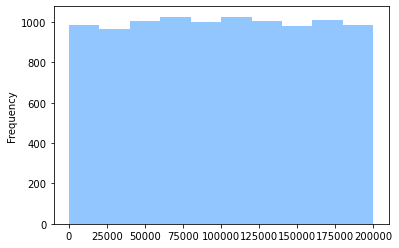

In [7]:
df['estimatedsalary'].plot(kind='hist')

<AxesSubplot:>

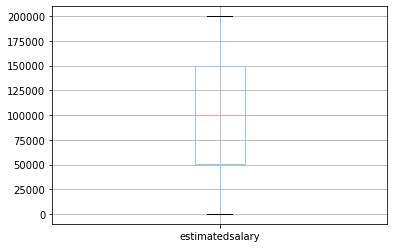

In [8]:
df.boxplot(column=['estimatedsalary'])

In [9]:
df.drop(columns=['rownumber', 'customerid', 'surname'], inplace=True)

### Изучение и замена пропусков в `tenure`

In [10]:
df[df['tenure'].isnull()]['age'].describe() # Проверка гипотезы, что пропуски связаны с тем, что человек более 11 лет клиент

count   909.0
mean     38.6
std       9.8
min      18.0
25%      32.0
50%      37.0
75%      43.0
max      92.0
Name: age, dtype: float64

<AxesSubplot:>

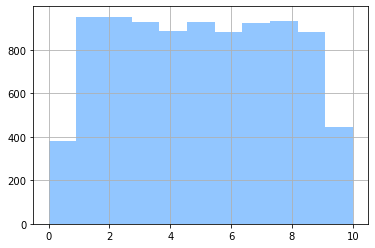

In [11]:
df['tenure'].hist(bins=11)

In [12]:
print('Нулевые значения:', len(df[df['tenure'].isnull()]))
print('Отказалось от услуг:', len(df.query('exited == 1')))
print('Пропуски значений и отказались от услуг', len(df[df['tenure'].isnull() & df['exited'] == 1]))

Нулевые значения: 909
Отказалось от услуг: 2037
Пропуски значений и отказались от услуг 183


In [13]:
df['tenure_age'] = df['age'] - df['tenure']

In [14]:
df['tenure_age'].describe()

count   9,091.0
mean       34.0
std        11.0
min         8.0
25%        26.0
50%        32.0
75%        39.0
max        91.0
Name: tenure_age, dtype: float64

In [15]:
len(df.query('tenure_age <= 17'))

298

Обнаружили интересное являение: 3% пользователей пользуются услгами до совершенолетия, а рекордсмен - с 8лет имеет счет в банке. Данные не очень достоверны, но все же попробуем сначало обучить с ними, потом без них.

In [16]:
df['non_value'] = df['tenure'].isnull()

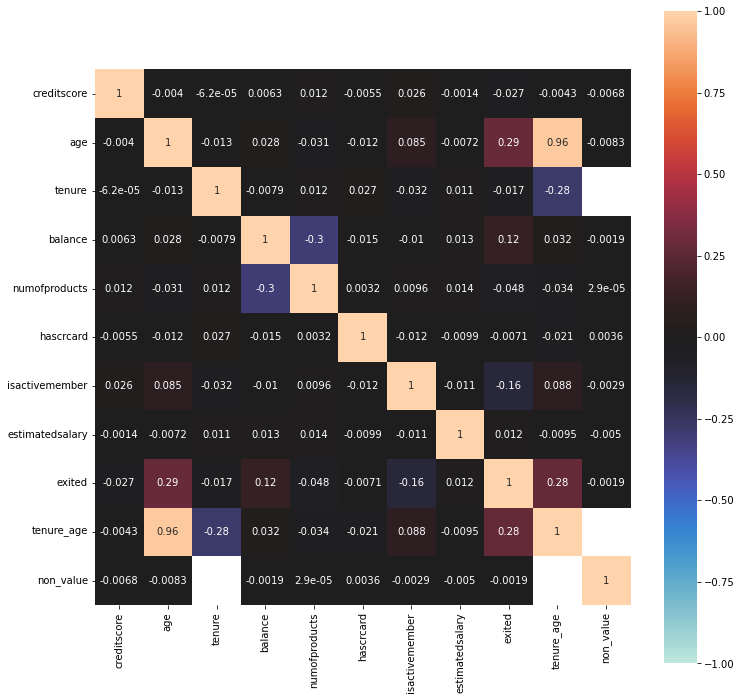

In [17]:

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.corr(), annot=True, square=True, vmin=-1, vmax=1, center=0, ax=ax)
plt.show()
del fig, ax

In [18]:
df.drop(columns=['non_value', 'tenure_age'], inplace=True)

Посмотрел зависимости, чтоб понять природу пропусков. пропуски судя по всему имеют все же случайный характер, поэтому будем заполним также случайными значениями

In [19]:
def random_tenure(row):
    if pd.isnull(row['tenure']):
        row['tenure'] = randint(0,10)
    return row
df = df.apply(random_tenure, axis=1)

<AxesSubplot:>

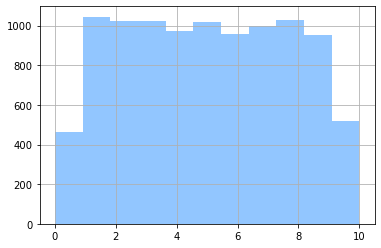

In [20]:
df['tenure'].hist(bins=11) # посмотрел на сколько рандомно заполнилось

In [21]:
df['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

### Кодирование категориальных переменных

In [22]:
df.head(5)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.0,1,1,1,"101,348.9",1
1,608,Spain,Female,41,1.0,"83,807.9",1,0,1,"112,542.6",0
2,502,France,Female,42,8.0,"159,660.8",3,1,0,"113,931.6",1
3,699,France,Female,39,1.0,0.0,2,0,0,"93,826.6",0
4,850,Spain,Female,43,2.0,"125,510.8",1,1,1,"79,084.1",0


In [23]:
df = pd.get_dummies(df, columns=['gender'], drop_first=True) # Gender -> OHE

In [24]:
df = pd.get_dummies(df, columns=['geography'], drop_first=True)

### Разбивка на валидационную/тестовую/обучающающую выборки

In [25]:
print(len(df.query('exited == 0')))
print(len(df.query('exited == 1')))

7963
2037


In [26]:
target = df['exited']
features = df.drop(columns=['exited'])
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=123, stratify=df['exited'])


### Масштабирование признаков

In [27]:
scaler = StandardScaler()
scaler.fit(features_train)
features_scaled_train = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns)
features_scaled_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)

### Вывод по подготовке данных

- кодированы признаки `country` (Ordinal Encording) и `age` (OHE)
- подготовлена дополнительная выборка с масштабированными признаками
- признак `tenure` не выглядит достоверным

## Борьба с дисбалансом

In [28]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=123)
    
    features_upsampled.columns = features.columns
    
    return features_upsampled, target_upsampled

features_balance_train, target_balance_train = upsample(features_train, target_train, 4)


In [29]:
print(len(target_balance_train[target == 1])) 
print(len(target_balance_train[target == 0]))

6112
5972


Подготовлена выборка сбалансированная методом `upsampling`

## Тестирование модели

### Случайный лес не сбалансированный

In [30]:
model_forest = RandomForestClassifier(random_state=123)
params_forest = {'n_estimators': range (10, 101, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,3)}
grid_forest = GridSearchCV(model_forest, param_grid=params_forest)
grid_forest.fit(features_train, target_train)
predict = grid_forest.predict(features_test)
print('f1_score:', f1_score(target_test, predict))
print('roc_auc_score:', roc_auc_score(target_test, predict))
print('параметры', str(grid_forest.best_params_))

f1_score: 0.5965346534653466
roc_auc_score: 0.7221731583875968
параметры {'max_depth': 11, 'min_samples_leaf': 2, 'n_estimators': 20}


### Случайный лес с масштабированными признаками

In [32]:
model_forest = RandomForestClassifier(random_state=123)
params_forest = {'n_estimators': range (10, 101, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,3)}
grid_forest = GridSearchCV(model_forest, param_grid=params_forest)
grid_forest.fit(features_scaled_train, target_train)
predict = grid_forest.predict(features_scaled_test)
print('f1_score:', f1_score(target_test, predict))
print('roc_auc_score:', roc_auc_score(target_test, predict))
print('параметры', str(grid_forest.best_params_))

f1_score: 0.5965346534653466
roc_auc_score: 0.7221731583875968
параметры {'max_depth': 11, 'min_samples_leaf': 2, 'n_estimators': 20}


### Логистическая регрессия

In [33]:
model_logic = LogisticRegression()
model_logic.fit(features_train, target_train)
predict = model_logic.predict(features_test)
print('f1_score', f1_score(target_test, predict))
print('roc_auc_score:', roc_auc_score(target_test, predict))

f1_score 0.11092436974789917
roc_auc_score: 0.5191066084215906


### Логистическая регрессия c масштабированными признаками

In [34]:
model_logic = LogisticRegression()
model_logic.fit(features_scaled_train, target_train)
predict = model_logic.predict(features_scaled_test)
print('f1_score', f1_score(target_test, predict))
print('roc_auc_score:', roc_auc_score(target_test, predict))

f1_score 0.3222222222222222
roc_auc_score: 0.5900915613384


### Логистическая регрессия c масштабированными признаками

In [35]:
model_logic = LogisticRegression(class_weight='balanced')
model_logic.fit(features_scaled_train, target_train)
predict = model_logic.predict(features_scaled_test)
print('f1_score', f1_score(target_test, predict))
print('roc_auc_score:', roc_auc_score(target_test, predict))

f1_score 0.4691011235955056
roc_auc_score: 0.6821877229457904


### Случайный лес с балансированными классами (upsampling)

In [36]:
model_forest = RandomForestClassifier(random_state=123)
params_forest = {'n_estimators': range (10, 101, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,3)}
grid_forest = GridSearchCV(model_forest, param_grid=params_forest)
grid_forest.fit(features_balance_train, target_balance_train)
predict = grid_forest.predict(features_test)
print('f1_score:', f1_score(target_test, predict))
print('roc_auc_score:', roc_auc_score(target_test, predict))
print('параметры', str(grid_forest.best_params_))

f1_score: 0.6050269299820467
roc_auc_score: 0.7637383944844137
параметры {'max_depth': 11, 'min_samples_leaf': 1, 'n_estimators': 100}


### Случайный лес с балансированным классом (`balanced`)

In [37]:
model_forest = RandomForestClassifier(random_state=123, class_weight='balanced')
params_forest = {'n_estimators': range (10, 101, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,3)}
grid_forest = GridSearchCV(model_forest, param_grid=params_forest)
grid_forest.fit(features_train, target_train)
predict = grid_forest.predict(features_test)
print('f1_score:', f1_score(target_test, predict))
print('roc_auc_score:', roc_auc_score(target_test, predict))
print('параметры', str(grid_forest.best_params_))

f1_score: 0.621105527638191
roc_auc_score: 0.7590863206630228
параметры {'max_depth': 11, 'min_samples_leaf': 1, 'n_estimators': 80}


### Случайный лес с удаленным `tenure`

In [38]:
features_train.drop(columns=['tenure'], inplace=True)
features_test.drop(columns=['tenure'], inplace=True)

In [39]:
model_forest = RandomForestClassifier(random_state=123, class_weight='balanced')
params_forest = {'n_estimators': range (10, 101, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,3)}
grid_forest = GridSearchCV(model_forest, param_grid=params_forest)
grid_forest.fit(features_train, target_train)
predict = grid_forest.predict(features_test)
print('f1_score:', f1_score(target_test, predict))
print('roc_auc_score:', roc_auc_score(target_test, predict))
print('параметры', str(grid_forest.best_params_))

f1_score: 0.6392785571142284
roc_auc_score: 0.770667413971911
параметры {'max_depth': 11, 'min_samples_leaf': 1, 'n_estimators': 80}


  
**Проделано:**  

- Протестированы модели случайного леса и логистической регрессии с различными гипперпараметрами.
- Протестированы модели с различными методами балансировки классов.  
- Протестированы модели с/без признака `tenure`

**Вывод:**  
   
- Балансировка класса методом upsampling не дает принципиального преимущества к методу взвешивания классов, но из-за сложности использования первого, проще балансировать классы методом взвешивания. Предполгаю, что методы upsampling и downsampling лучше показывают себя при сильном дисбалансе классе в первоночальной выборке  
- масштабирования признаков при обучение случайного леса преимущества не дало, однако при обучение модели Логистической регрессии, f1-мера увеличилась более чем в 2раза.
- Удаление признак `tenure` не повлияло на качество обученной модели из этого можно сделать 2предположения, что уход пользователей никак не зависит от того сколько лет они являются клиентами банка(Наврядли) либо данные предоставлены не качественные(что более вероятно)